In [1]:
import pickle
import gzip
import numpy as np
import scipy
import pandas as pd
import tensorflow as tf
import keras
import keras.layers as layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.layers import Input, LSTM, Dense, Lambda, Conv1D, Conv2D, AveragePooling2D, AveragePooling1D, Flatten, MaxPooling2D, MaxPooling1D, Dropout
from keras.models import Model
from keras.models import Sequential
from keras.utils import Sequence
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop
from keras.applications import imagenet_utils
from keras import backend as K
from time import time
from keras import losses
from sklearn.metrics import  roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score, mean_absolute_error
import glob
from PIL import Image
import h5py
import random
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.gaussian_process as gp
import pandas as pd
import pickle
from joblib import dump, load
from sklearn.utils import shuffle
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Dec 17 03:01:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !rm -R qmc qmc1
    !git clone https://github.com/fagonzalezo/qmc.git
    !mv qmc qmc1
    !mv qmc1/qmc .
else:
    import sys
    sys.path.insert(0, "../")

rm: cannot remove 'qmc': No such file or directory
rm: cannot remove 'qmc1': No such file or directory
Cloning into 'qmc'...
remote: Enumerating objects: 215, done.
remote: Total 215 (delta 0), reused 0 (delta 0), pack-reused 215
Receiving objects: 100% (215/215), 17.06 MiB | 8.72 MiB/s, done.
Resolving deltas: 100% (91/91), done.


In [ ]:
import qmc.tf.layers as layers
import qmc.tf.models as models

/usr/local/lib/python3.6/dist-packages/typeguard/__init__.py:804: UserWarning: no type annotations present -- not typechecking qmc.tf.layers.CrossProduct.__init__
  warn('no type annotations present -- not typechecking {}'.format(function_name(func)))
/usr/local/lib/python3.6/dist-packages/typeguard/__init__.py:804: UserWarning: no type annotations present -- not typechecking qmc.tf.layers.DensityMatrix2Dist.__init__
  warn('no type annotations present -- not typechecking {}'.format(function_name(func)))
/usr/local/lib/python3.6/dist-packages/typeguard/__init__.py:804: UserWarning: no type annotations present -- not typechecking qmc.tf.layers.DensityMatrixRegression.__init__
  warn('no type annotations present -- not typechecking {}'.format(function_name(func)))


In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/ICML2021/diabetes/data/diabetes.data_train_5.1', header = None, sep = ' ')
X = data.to_numpy()
y = X[:,2]
X = X[:,0:2]

Los labels van de 1 a 5

In [ ]:
print(max(y))
print(min(y))

5.0
1.0


In [ ]:
y = (y-1)/4
y = np.float64(y)
y = y.reshape((30,1))
X = np.float64(X)

Normalizando los datos:

In [ ]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [ ]:
from scipy.spatial import distance

distances = distance.cdist(X, X, 'euclidean')

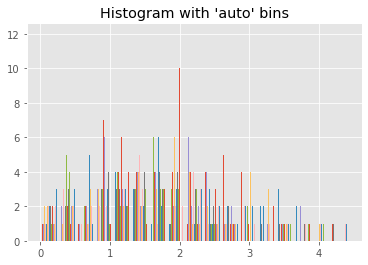

In [ ]:
import matplotlib.pyplot as plt

_ = plt.hist(distances, bins='auto')  # arguments are passed to np.histogram

plt.title("Histogram with 'auto' bins")

plt.show()

Sigma:

In [ ]:
print(np.mean(distances))
print(np.median(distances))

1.730574947599839
1.7011029955629449


Gamma:

In [ ]:
print(1/(np.mean(distances)**2))
print(1/(np.median(distances)**2))

0.33390211898025207
0.3455721868426817


In [ ]:
BIG_MAE=[]
for i in range(20):
    print('----------------------------------------',i)
    number = str(i+1)
    train_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/diabetes/data/diabetes.data_train_5.'
    test_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/diabetes/data/diabetes.data_test_5.'
    
    data = pd.read_csv(train_path+number, header = None, sep = ' ')
    X = data.to_numpy()
    y = X[:,2]
    X = X[:,0:2]

    y = (y-1)/4
    y = np.float64(y)
    y = y.reshape((30,1))
    X = np.float64(X)

    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)

    MAE_opt = 100
    dim_y = 5
    for i in range(24):

        beta = 1 + np.random.sample()*19.9
        gamma = 0.01 + np.random.sample()*0.99
        learning_rate = 0.00000001 + np.random.sample()*0.00009999
        alpha = np.random.sample()
        dim_x = np.random.choice([512, 256, 128])
        dim_x = int(dim_x)
        num_eig = np.random.choice([int(dim_x/8), int(dim_x/16), int(dim_x/32)])
        num_eig = int(num_eig)

        #print('------------', i+1, 'beta=', beta, 'gamma=', gamma, 'learning_rate=', learning_rate, 'alpha=', alpha, 'dim_x=', dim_x, 'num_eig=', num_eig)

        MAE = []

        fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta)
        fm_x = layers.QFeatureMapRFF(2, dim=dim_x, gamma=gamma, random_state=1)
        qmr2 = models.QMRegressorSGD(input_dim=2, dim_x=dim_x, num_eig=num_eig, dim_y=dim_y, gamma=gamma, random_state=17)

        # for initialize weights

        qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x, dim_y=dim_y)
        
        kf = KFold(n_splits=5)

        #for i in range(5): 
            
        for train, test in kf.split(X):

            X_train = X[train]
            y_train = y[train]
            X_test = X[test]
            y_test = y[test]

            qmr.compile()
            qmr.fit(X_train, y_train, epochs=1, batch_size = 4, verbose = 0)

            qmr2.set_rho(qmr.get_rho())
            # Train model with SGD
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            qmr2.layers[0].trainable = True

            def loss(y_true, y_pred):
                return tf.keras.losses.MAE(y_true, y_pred[:,0:1]) + alpha * tf.math.sqrt(y_pred[:, 1:2])

            qmr2.compile(optimizer, loss=loss)
            qmr2.set_rho(qmr.get_rho())
            early_stop = EarlyStopping( monitor="val_loss",
                                        min_delta=0,
                                        patience=5,
                                        verbose=0,
                                        mode="auto",
                                        restore_best_weights=True,
                                        )

            qmr2.fit(X_train, y_train, epochs=60, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose=0)

            out = qmr2.predict(X_test, batch_size = 4)
            y_pred, std = out[:, 0], np.sqrt(out[:, 1])

            MAE.append(mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))

        if np.mean(MAE) < MAE_opt:
            MAE_opt = np.mean(MAE)
            beta_opt = beta
            gamma_opt = gamma
            learning_rate_opt = learning_rate
            alpha_opt = alpha
            dim_x_opt = dim_x   
            num_eig_opt = num_eig

        #print('---------------------mean MAE =', np.mean(MAE), ' , std =', np.std(MAE))

    print('MAE = ',MAE_opt, 'beta = ',beta_opt, 'gamma = ', gamma_opt, 'learning_rate = ', learning_rate_opt, 'alpha = ', alpha_opt, 'dim_x = ', dim_x_opt, 'num_eig = ', num_eig_opt)

    X_train = X
    y_train = y

    X_test = pd.read_csv(test_path+number, header = None, sep = ' ')
    X_test = X_test.to_numpy()
    X_test = np.float64(X_test)
    y_test = X_test[:,2]
    X_test = X_test[:,0:2]
    X_test = scaler.transform(X_test)
    y_test = (y_test-1)/4
    y_test = np.float64(y_test)
    y_test = y_test.reshape((13,1))

    fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta_opt)
    fm_x = layers.QFeatureMapRFF(2, dim=dim_x_opt, gamma=gamma_opt, random_state=1)
    qmr2 = models.QMRegressorSGD(input_dim=2, dim_x=dim_x_opt, num_eig=num_eig_opt, dim_y=dim_y, gamma=gamma_opt, random_state=17)

    # for initialize weights

    qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x_opt, dim_y=dim_y)
    qmr.compile()
    qmr.fit(X_train, y_train, epochs=1, batch_size = 4)

    qmr2.set_rho(qmr.get_rho())
    # Train model with SGD
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_opt)
    qmr2.layers[0].trainable = True

    def loss(y_true, y_pred):
        return tf.keras.losses.MAE(y_true, y_pred[:,0:1]) + alpha_opt * tf.math.sqrt(y_pred[:, 1:2])

    qmr2.compile(optimizer, loss=loss)
    qmr2.set_rho(qmr.get_rho())
    early_stop = EarlyStopping( monitor="val_loss",
                                min_delta=0,
                                patience=5,
                                verbose=0,
                                mode="auto",
                                restore_best_weights=True,
                                )

    qmr2.fit(X_train, y_train, epochs=100, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose = 0)

    out = qmr2.predict(X_test, batch_size = 4)
    y_pred, std = out[:, 0], np.sqrt(out[:, 1])
    print('------------MAE =', mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))
    BIG_MAE.append(mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))

---------------------------------------- 0
MAE =  0.6666666666666666 beta =  18.97464083876514 gamma =  0.12169514128844686 learning_rate =  6.030018510861621e-05 alpha =  0.8163147620522997 dim_x =  256 num_eig =  32
8/8 [==============================] - 0s 2ms/step
------------MAE = 0.6153846153846154
---------------------------------------- 1
MAE =  0.6666666666666666 beta =  9.043168102743694 gamma =  0.05240022863093607 learning_rate =  6.990535787037228e-05 alpha =  0.8255350262052531 dim_x =  256 num_eig =  8
8/8 [==============================] - 0s 3ms/step
------------MAE = 0.6153846153846154
---------------------------------------- 2
MAE =  0.6666666666666666 beta =  5.028259364023922 gamma =  0.2757827365865246 learning_rate =  7.361389934268323e-05 alpha =  0.33562838770744496 dim_x =  256 num_eig =  32
8/8 [==============================] - 0s 2ms/step
------------MAE = 0.6923076923076923
---------------------------------------- 3
MAE =  0.6666666666666666 beta =  9.0644

In [2]:
BIG_MAE = [0.6153846153846154, 0.6153846153846154, 0.6923076923076923, 0.5384615384615384, 0.6153846153846154,
           0.6153846153846154, 0.6153846153846154, 0.5384615384615384, 0.6153846153846154, 0.6923076923076923,
           0.6153846153846154, 0.7692307692307693, 0.6923076923076923, 0.6153846153846154, 0.6153846153846154,
           0.6153846153846154, 0.6153846153846154, 0.6153846153846154, 0.6153846153846154, 0.6153846153846154]

In [3]:
print(np.mean(BIG_MAE))
print(np.std(BIG_MAE))

0.6269230769230768
0.05029498781008469
